### Motivation

Goal of this post is to compare some sequence shape comparison criteria. This should be considered as a naive introduction to the topic.

### Theoretical statements
- <i>Cross-correlation</i> is used to recognize a noisy signal by comparing it with its noiseless version. If a signal is symmetrical, cross-correlation is mathematically equivalent to the convolution.
- <i>Cross-covariance</i> corresponds to the cross-correlation of two zero-mean sequences. If two sequences have 0 mean, then their covariance is same as their correlation.
- Two stochastic processes are called uncorrelated if their covariance is zero for all times
- <i>Cosine similarity</i> is a metric used to measure the distance between two vectors without consindering their magnitude. The similarity is here measured on their orientation. It is used e.g. to match a document to a query whereby the frequency of the query occuring within the document should not be affected by the document's length (since longer documents could easily increase the query frequency)
- <i>Dynamit Time Warping (DTW)</i> algorithm measures the similarity of two temporal sequences, which vary differently in the time domain. For example, two voices speaking at different speed may be compared using DTW. The Python implementation here is an approximation, called fast DTW.
- <i>Pearson coefficient</i> is a measure (from -1 to +1) of the linear correlation between two variables. A value of 0 means no linear correlation, +1 positive linear correlation, - and −1 negative linear correlation. It corresponds to the covariance of two variable divided by the product of their standard deviation. In the following implementation I modified the result by finally taking its absolute value.
- <i>Spearman coefficient</i> (also from -1 to +1) tells how well a monotonic function can be used to describe the relationship between two variables. It corresponds to the Pearson coefficient between ranks of two variables. A ranked variable is a variable having values which can be put in order. For example, the sequence 2.3, 4.1, 1.2, 5 can be sorted as 1.2(=1st), 2.3(=2nd), 4.1(=3rd), 5(=4th) and therefore the equivaled ranked sequence would be 2, 3, 1, 4. In the following implementation I modified the result by finally taking its absolute value.
- <i>Form and crest factor</i> are called waveform factors and are related to their shapes. The latter describes how extreme the peaks are in a waveform. Both factors are mixed here as components of a vector for each sequence and the resulting cosine similarity is measured.
- Applying the <i>Softmax</i> function to a vector will map each component in the interval from 0 to 1 in such a way to make the components sum equal to 1. These values can be interpreted as probabilities.

### Implementation

Needed libraries

In [1]:
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.special import softmax
from difflib import SequenceMatcher

Data preparation and visualization functions:

In [2]:
def plotTemplates(templates):
    """
    templates should be given as a list of two value tuples,
    whereby the first value is a numpy array of the desired sequence
    and the second one is a label associated to it
    """
    for t in templates:
        plt.plot(t[0], label=t[1])
        plt.legend()
        
def normalizeSequence(sequence, newLength):
    """
    Goal of this normalization function is not only
    to fit the input sequence to a fixed range from 0 to 1
    but also to change its length by linearly interpolating
    (sampling) it at regular interval.
    """ 
    t = np.linspace(0,1,newLength)
    ts = np.linspace(0,1,len(sequence))
    sequence = sequence / max(sequence)
    sequence = np.interp(t,ts,sequence)
    return sequence

def normalizeTemplates(templates, newLength):
    return [(normalizeSequence(x[0], newLength), x[1]) for x in templates]

def normalizedSequenceFromTemplates(templates, newLength):
    return [normalizeSequence(x[0], newLength) for x in templates]

def normalizedSequenceFromTemplates_frequency_domain(templates, newLength):
    return [normalizeSequence(np.fft.fft(x[0]), newLength) for x in templates]

def labelsFromTemplates(templates):
    return [x[1] for x in templates]

Sequence similarity evaluation functions. The numerical result shall be later converted into a probability (using Softmax). The larger the value, the greater is the probability of two sequences being similar. In order to make this statement hold, some result will be multiplied by -1.

In [3]:
def correlation_criterion(sequence1, sequence2):
    res = sum(np.correlate(sequence1, sequence2, 'full'))
    return res

def correlation_criterion_v1(sequence1, sequence2):
    """
    The basic idea of this function is: the nearer the cross-correlation
    is to the auto-correlation, the more similar is the auto-correlated sequence
    to the other one.
    """
    res = sum(abs(np.correlate(sequence1, sequence1, 'full') - np.correlate(sequence1, sequence2, 'full')))
    return res*(-1)
    
def correlation_criterion_v2(sequence1, sequence2):
    """
    Differently than correlation_criterion_v1, here also the comparison is done
    in both orders/directions.    
    """
    res1 = sum(abs(np.correlate(sequence1, sequence1, 'full') - np.correlate(sequence1, sequence2, 'full')))
    res2 = sum(abs(np.correlate(sequence2, sequence2, 'full') - np.correlate(sequence2, sequence1, 'full')))
    return (res1+res2)*(-1)

def covariance_criterion_v1(sequence1, sequence2):
    return np.absolute(np.cov(sequence1)-np.cov(sequence2))*(-1)

def covariance_criterion_v2(sequence1, sequence2):
    return np.absolute(np.cov(sequence1-sequence2))*(-1)

def cosine_similarity_criterion(sequence1, sequence2):
    return cosine(sequence1, sequence2)

def fast_dtw_criterion(sequence1, sequence2):
    distance, path = fastdtw(sequence1, sequence2, dist=euclidean)
    return distance*(-1)

def pearson_criterion(sequence1, sequence2):
    return np.absolute(pearsonr(sequence1, sequence2)[0])
    
def form_crest_factor_criterion(sequence1, sequence2):
    rms1 = np.sqrt(np.mean(sequence1**2))
    rms2 = np.sqrt(np.mean(sequence2**2))
    
    peak1 = np.max(np.absolute(sequence1))
    peak2 = np.max(np.absolute(sequence2))
    
    arv1 = np.mean(np.absolute(sequence1))
    arv2 = np.mean(np.absolute(sequence2))

    crest_factor1 = peak1 / rms1
    crest_factor2 = peak2 / rms2
    
    form_factor1 = rms1 / arv1
    form_factor2 = rms2 / arv2

    vector1 = np.array([form_factor1, crest_factor1])
    vector2 = np.array([form_factor2, crest_factor2])
    
    return cosine(vector1,vector2)
    
def variance_criterion_v1(sequence1, sequence2):
    return np.absolute(np.var(sequence1)-np.var(sequence2))*(-1)

def variance_criterion_v2(sequence1, sequence2):
    return np.var(sequence1-sequence2)*(-1)

def spearman_criterion(sequence1, sequence2):
    return np.absolute(spearmanr(sequence1, sequence2).correlation)*(-1)


def sequence_matcher(sequence1, sequence2):
    return SequenceMatcher(None, sequence1, sequence2).ratio()



criteria = [correlation_criterion,
            correlation_criterion_v1,
            correlation_criterion_v2,
            covariance_criterion_v1,
            covariance_criterion_v2,
            cosine_similarity_criterion,
            fast_dtw_criterion,
            pearson_criterion,
            form_crest_factor_criterion,
            variance_criterion_v1,
            variance_criterion_v2,
            spearman_criterion,
            sequence_matcher]

Decision function:

In [4]:
def decide(sequence, templatesSequence, criterion):
    '''
    The decision is taken according to the chosen criterion function.
    The resulting values for each template are collected inside a vector
    and filtered with the softmax function so that a probabilistic
    interpretation is possible.
    '''
    res = np.asarray([criterion(sequence, template) for template in templatesSequence])
    return np.argmin(res)

def decide_loop(sequence, templatesSequence, criteria):
    return [decide(sequence, templatesSequence, criterion) for criterion in criteria]

def compare(sequence, templatesSequence, criterion):
    res = np.asarray([criterion(sequence, template) for template in templatesSequence])
    return np.around(softmax(res),decimals=2)
    

def compare_loop_print(sequence, templates, criteria, newLength):
    table = []
    sum_results = np.array([0]*len(templates))
    for criterion in criteria:
        normalizedSequence = normalizeSequence(sequence, newLength)
        templatesSequence = normalizedSequenceFromTemplates(templates, newLength)
        result = compare(normalizedSequence, templatesSequence, criterion)
        table_row = [criterion.__name__] + result.tolist()
        table.append(table_row)
    headers = ["Criterion"] + labelsFromTemplates(templates)
    print(tabulate(table, headers))
    
def compare_loop_print_frequency_domain(sequence, templates, criteria, newLength):
    table = []
    sum_results = np.array([0]*len(templates))
    for criterion in criteria:
        normalizedSequence = normalizeSequence(np.fft.fft(sequence), newLength)
        templatesSequence = normalizedSequenceFromTemplates_frequency_domain(templates, newLength)
        result = abs(compare(normalizedSequence, templatesSequence, criterion))
        table_row = [criterion.__name__] + result.tolist()
        table.append(table_row)
    headers = ["Criterion"] + labelsFromTemplates(templates)
    print(tabulate(table, headers))

Definition of shapes as template to classify later sequences. Any sequence can be given with different lengths and magnitudes, since a later normalization step will map them into fixed ranges.
The variable templates will store the list of templates together with user defined label in a tuple.

In [5]:
templates = []
templates.append((np.asarray([1,2,3,4,5,4,3,2,1]), "Triangle"))
templates.append((np.asarray([1,10]), "Line (asc)"))
templates.append((np.asarray([10,1]), "Line (desc)"))
templates.append((np.asarray([1,5,2,6,3,7,4,8,5,9]), "Zig-zag (asc)"))
templates.append((np.asarray([9, 5, 8, 4, 7, 3, 6, 2, 5, 1]), "Zig-zag (desc)"))
templates.append((5*np.sin(np.linspace(-np.pi, np.pi, 20)), "Sinus"))
newLength = 200 # Length of any sequence after normalization

Plot of templates as they are:

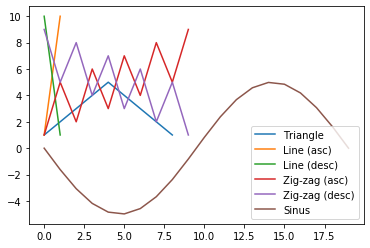

In [6]:
plotTemplates(templates)

Now applying normalization:

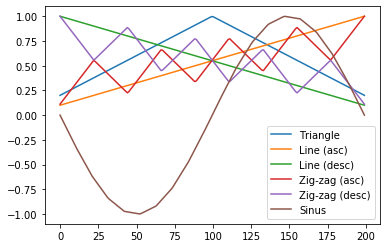

In [7]:
templates_norm = normalizeTemplates(templates, newLength)
plotTemplates(templates_norm)

Now we define some sample sequences to be classified according to the given templates.

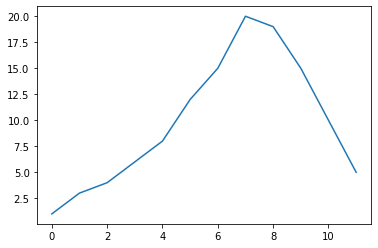

Criterion                      Triangle    Line (asc)    Line (desc)    Zig-zag (asc)    Zig-zag (desc)    Sinus
---------------------------  ----------  ------------  -------------  ---------------  ----------------  -------
correlation_criterion              1             0              0                0                 0        0
correlation_criterion_v1           0             1              0                0                 0        0
correlation_criterion_v2           0             0              0                1                 0        0
covariance_criterion_v1            0.18          0.18           0.18             0.17              0.17     0.12
covariance_criterion_v2            0.18          0.18           0.15             0.18              0.16     0.15
cosine_similarity_criterion        0.14          0.14           0.18             0.14              0.16     0.24
fast_dtw_criterion                 1             0              0                0                 0     

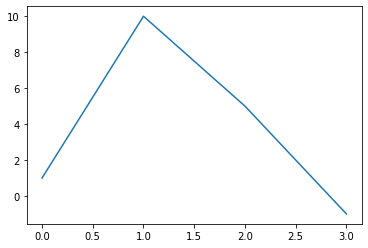

Criterion                      Triangle    Line (asc)    Line (desc)    Zig-zag (asc)    Zig-zag (desc)    Sinus
---------------------------  ----------  ------------  -------------  ---------------  ----------------  -------
correlation_criterion              1             0              0                0                 0        0
correlation_criterion_v1           0             0              0                0                 1        0
correlation_criterion_v2           0             0              0                0                 1        0
covariance_criterion_v1            0.18          0.18           0.18             0.17              0.17     0.12
covariance_criterion_v2            0.2           0.16           0.19             0.17              0.19     0.09
cosine_similarity_criterion        0.11          0.14           0.12             0.13              0.12     0.38
fast_dtw_criterion                 1             0              0                0                 0     

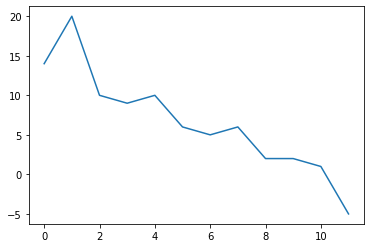

Criterion                      Triangle    Line (asc)    Line (desc)    Zig-zag (asc)    Zig-zag (desc)    Sinus
---------------------------  ----------  ------------  -------------  ---------------  ----------------  -------
correlation_criterion              1             0              0                0                 0        0
correlation_criterion_v1           0             0              1                0                 0        0
correlation_criterion_v2           0             0              1                0                 0        0
covariance_criterion_v1            0.18          0.18           0.18             0.17              0.17     0.12
covariance_criterion_v2            0.18          0.16           0.21             0.17              0.2      0.09
cosine_similarity_criterion        0.12          0.16           0.1              0.14              0.1      0.38
fast_dtw_criterion                 0             0              1                0                 0     

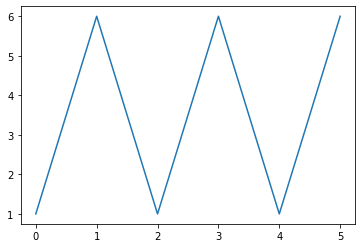

Criterion                      Triangle    Line (asc)    Line (desc)    Zig-zag (asc)    Zig-zag (desc)    Sinus
---------------------------  ----------  ------------  -------------  ---------------  ----------------  -------
correlation_criterion              1             0              0                0                 0        0
correlation_criterion_v1           1             0              0                0                 0        0
correlation_criterion_v2           1             0              0                0                 0        0
covariance_criterion_v1            0.18          0.18           0.18             0.18              0.18     0.12
covariance_criterion_v2            0.18          0.18           0.17             0.18              0.18     0.11
cosine_similarity_criterion        0.13          0.14           0.14             0.13              0.13     0.33
fast_dtw_criterion                 0             0              0                1                 0     

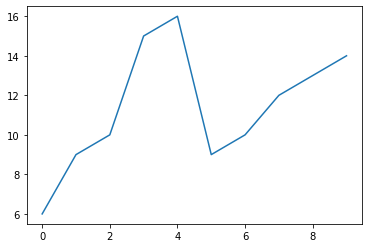

Criterion                      Triangle    Line (asc)    Line (desc)    Zig-zag (asc)    Zig-zag (desc)    Sinus
---------------------------  ----------  ------------  -------------  ---------------  ----------------  -------
correlation_criterion              1             0              0                0                 0        0
correlation_criterion_v1           1             0              0                0                 0        0
correlation_criterion_v2           1             0              0                0                 0        0
covariance_criterion_v1            0.18          0.17           0.17             0.18              0.18     0.11
covariance_criterion_v2            0.18          0.18           0.17             0.18              0.18     0.11
cosine_similarity_criterion        0.13          0.13           0.14             0.13              0.13     0.34
fast_dtw_criterion                 0             0              0                1                 0     

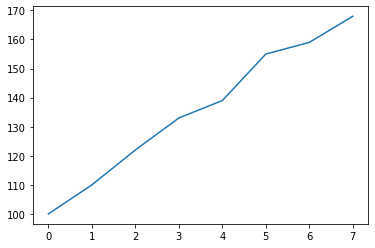

Criterion                      Triangle    Line (asc)    Line (desc)    Zig-zag (asc)    Zig-zag (desc)    Sinus
---------------------------  ----------  ------------  -------------  ---------------  ----------------  -------
correlation_criterion              1             0              0                0                 0        0
correlation_criterion_v1           1             0              0                0                 0        0
correlation_criterion_v2           1             0              0                0                 0        0
covariance_criterion_v1            0.18          0.17           0.17             0.18              0.18     0.11
covariance_criterion_v2            0.17          0.18           0.16             0.18              0.17     0.13
cosine_similarity_criterion        0.14          0.13           0.15             0.13              0.14     0.31
fast_dtw_criterion                 0             0.46           0                0.54              0     

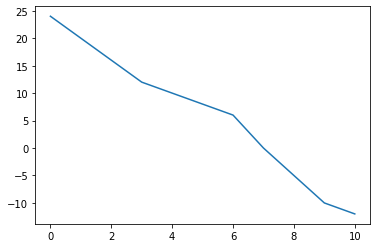

Criterion                      Triangle    Line (asc)    Line (desc)    Zig-zag (asc)    Zig-zag (desc)    Sinus
---------------------------  ----------  ------------  -------------  ---------------  ----------------  -------
correlation_criterion              1             0              0                0                 0        0
correlation_criterion_v1           0             0              1                0                 0        0
correlation_criterion_v2           0             0              1                0                 0        0
covariance_criterion_v1            0.17          0.17           0.17             0.17              0.17     0.14
covariance_criterion_v2            0.18          0.14           0.22             0.16              0.21     0.08
cosine_similarity_criterion        0.12          0.18           0.09             0.15              0.1      0.37
fast_dtw_criterion                 0             0              1                0                 0     

In [8]:
sequences=[]
sequences.append(np.asarray([1,3,4,6,8,12,15,20,19,15,10,5]))
sequences.append(np.asarray([1,10,5,-1]))
sequences.append(np.asarray([14,20,10,9,10,6,5,6,2,2,1,-5]))
sequences.append(np.asarray([1,6,1,6,1,6]))
sequences.append(np.asarray([6,9,10,15,16,9,10,12,13,14]))
sequences.append(np.asarray([100,110,122,133,139,155,159,168]))
sequences.append(np.asarray([24,20,16,12,10,8,6,0,-5,-10,-12]))

for sequence in sequences:
    plt.plot(sequence)
    plt.show()
    compare_loop_print(sequence, templates, criteria, newLength)

What does it happen if we use the same criteria on the frequency domain of the given sequences?

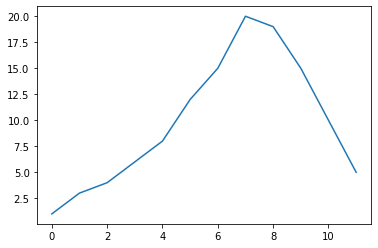

C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:3446: ComplexWarning: Casting complex values to real discards the imaginary part
  prob = 2*special.btdtr(ab, ab, 0.5*(1 - abs(np.float64(r))))


Criterion                      Triangle    Line (asc)    Line (desc)    Zig-zag (asc)    Zig-zag (desc)     Sinus
---------------------------  ----------  ------------  -------------  ---------------  ----------------  --------
correlation_criterion              0         0              0                1                     0     0
correlation_criterion_v1           1         0              0                0                     0     0
correlation_criterion_v2           1         0              0                0                     0     0
covariance_criterion_v1            0.21      0.17           0.2              0.21                  0.21  0
covariance_criterion_v2            0.21      0.17           0.21             0.21                  0.21  0
cosine_similarity_criterion        0.09      0.190263       0.290689         0.130384              0.14  0.161245
fast_dtw_criterion                 1         0              0                0                     0     0
pearson_criterio

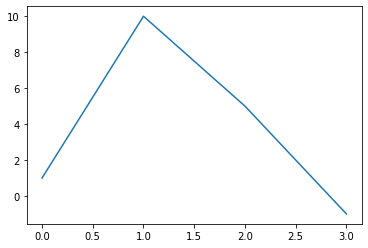

Criterion                      Triangle    Line (asc)    Line (desc)    Zig-zag (asc)    Zig-zag (desc)     Sinus
---------------------------  ----------  ------------  -------------  ---------------  ----------------  --------
correlation_criterion          1                 0          0                0                 0         0
correlation_criterion_v1       0                 1          0                0                 0         0
correlation_criterion_v2       1                 0          0                0                 0         0
covariance_criterion_v1        0.19              0.24       0.18             0.19              0.19      0
covariance_criterion_v2        0.2               0.19       0.2              0.2               0.21      0
cosine_similarity_criterion    0.220907          0.08       0.212132         0.310644          0.178885  0.23
fast_dtw_criterion             1                 0          0                0                 0         0
pearson_criterion   

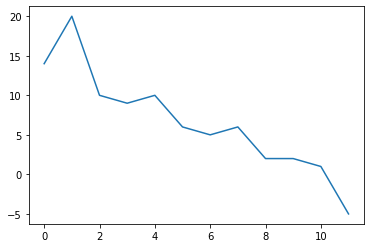

Criterion                      Triangle    Line (asc)    Line (desc)    Zig-zag (asc)    Zig-zag (desc)     Sinus
---------------------------  ----------  ------------  -------------  ---------------  ----------------  --------
correlation_criterion          0            0               1                0                 0         0
correlation_criterion_v1       0            0               0                0                 1         0
correlation_criterion_v2       0            0               0                0                 1         0
covariance_criterion_v1        0.21         0.18            0.2              0.21              0.21      0
covariance_criterion_v2        0.21         0.17            0.21             0.2               0.21      0
cosine_similarity_criterion    0.230868     0.0707107       0.213776         0.152643          0.20025   0.189737
fast_dtw_criterion             0            0               0                0                 1         0
pearson_criterio

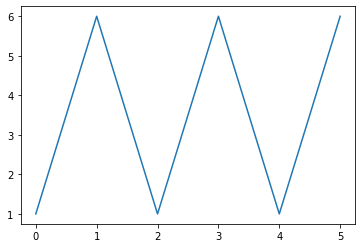

Criterion                      Triangle    Line (asc)    Line (desc)    Zig-zag (asc)    Zig-zag (desc)     Sinus
---------------------------  ----------  ------------  -------------  ---------------  ----------------  --------
correlation_criterion          0                 0              0            1                 0         0
correlation_criterion_v1       0                 0              0            1                 0         0
correlation_criterion_v2       0                 0              0            1                 0         0
covariance_criterion_v1        0.2               0.19           0.2          0.21              0.2       0
covariance_criterion_v2        0.2               0.18           0.2          0.21              0.2       0
cosine_similarity_criterion    0.150333          0.15           0.26         0.100499          0.181108  0.160312
fast_dtw_criterion             0.01              0              0            0.99              0         0
pearson_criterio

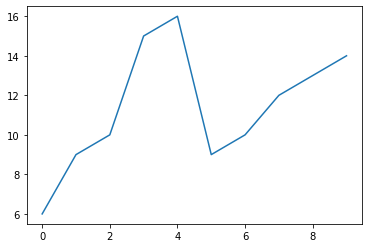

Criterion                      Triangle    Line (asc)    Line (desc)    Zig-zag (asc)    Zig-zag (desc)    Sinus
---------------------------  ----------  ------------  -------------  ---------------  ----------------  -------
correlation_criterion          0             0              1                    0             0            0
correlation_criterion_v1       0             0              0                    1             0            0
correlation_criterion_v2       1             0              0                    0             0            0
covariance_criterion_v1        0.21          0.17           0.2                  0.21          0.21         0
covariance_criterion_v2        0.21          0.17           0.2                  0.21          0.21         0
cosine_similarity_criterion    0.110454      0.181108       0.280179             0.12          0.130384     0.16
fast_dtw_criterion             0.87          0              0                    0.13          0            0
p

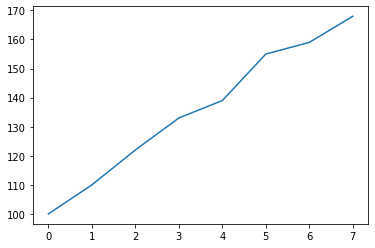

Criterion                      Triangle    Line (asc)    Line (desc)    Zig-zag (asc)    Zig-zag (desc)     Sinus
---------------------------  ----------  ------------  -------------  ---------------  ----------------  --------
correlation_criterion          0             0                  1                0             0         0
correlation_criterion_v1       0             0                  0                1             0         0
correlation_criterion_v2       1             0                  0                0             0         0
covariance_criterion_v1        0.21          0.17               0.2              0.21          0.21      0
covariance_criterion_v2        0.21          0.17               0.2              0.21          0.21      0
cosine_similarity_criterion    0.130384      0.181108           0.26             0.13          0.130384  0.160312
fast_dtw_criterion             0.45          0                  0                0.55          0         0
pearson_criterio

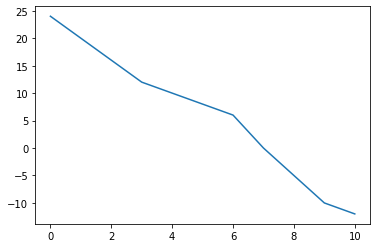

Criterion                      Triangle    Line (asc)    Line (desc)    Zig-zag (asc)    Zig-zag (desc)     Sinus
---------------------------  ----------  ------------  -------------  ---------------  ----------------  --------
correlation_criterion          0            0               1                0                 0         0
correlation_criterion_v1       0            0               0                0                 1         0
correlation_criterion_v2       0            0               0                0                 1         0
covariance_criterion_v1        0.2          0.21            0.19             0.2               0.2       0
covariance_criterion_v2        0.21         0.17            0.21             0.19              0.22      0
cosine_similarity_criterion    0.25632      0.0806226       0.184391         0.203961          0.200998  0.158114
fast_dtw_criterion             0            0               0                0                 1         0
pearson_criterio

In [9]:
for sequence in sequences:
    plt.plot(sequence)
    plt.show()
    compare_loop_print_frequency_domain(sequence, templates, criteria, newLength)

### Observations

Assumptions:
- A set of classes is given and must be sufficient to identify the given sequence
- Softmax applied
- Classes have very different characteristics 
- There is no negative ranking before application of Softmax
- No costant value as template

According to the given assumptions and samples, the fast_dtw_criterion gave a good human-liked hard-decision whereby the global shape is taken into account.
Correlation_criterion_v1 and correlation_criterion_v2 also are also hard-decision oriented but look meaningful only where they agree with each other.
It applies also in the frequency domain.